<a href="https://colab.research.google.com/github/gitpacho/solar-cell-simulation/blob/main/'(InGaN-InGaN)%3A%20Homojunction%20Simulation'.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contents

Libreries -- Constant values -- Solar Spectrum

1.   InGaN properties
2.   Basic Functions for simulate J vs V behaviour
    *  Basic functions
    *  Basic simulation
    *  Characteristic values
3.   SIMULATIONS (varying thickness and stoichiometry)
    * J vs V behaviour
    * P vs V behaviour
    * Comparative between J and P
    * Simulation Pmpp (Max Power Point)
    * Jsc, Voc, FF, efficiency results
    * Other results. Varying the doping


# Libreries -- Constant values -- Solar Spectrum

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
from scipy.interpolate import interp1d

Kb = 8.6 * 10  ** (-5)           # eV/K
q = 1.602 * 10 ** (-19)          # cm
T = 300                                # T
eps_0 = (8.85 * 10 ** -12) / 10000     # C^2 / (N*cm^2)
c = (3 * 10 ** 8) * 10 ** 9            # nm/s
h = 4.135667731 * 10 ** (-15)          # ev*s
m0 = 9.10938291 * 10 ** -31            # Kg

#Download the solar spectrum
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1neclBSg-ZIvyGf68ZDJ-ED5rOhFgeHjr' -O 'espectro.csv' 
spectrum = pd.read_csv('espectro.csv', header=0, delimiter=';', decimal = ",")

#We choose the AM1.5G spectrum
lamb  = np.array(spectrum.loc[(spectrum['Wvlgth nm'] <= 1937.0), 'Wvlgth nm'])
I_AM15  = np.array(spectrum.loc[(spectrum['Wvlgth nm'] <= 1937.0), 'Global tilt  W*m-2*nm-1'])
photon_flux = I_AM15 * lamb / (q * 1240) / 10000   # 1 / (cm² * nm)

#Total radiation in the material
I_AM15_  = np.array(spectrum['Global tilt  W*m-2*nm-1'])
P_inc = (integrate.simps(I_AM15_) / 10000) * 1000   # mW / cm²     # P_inc = 100

--2021-03-26 21:33:18--  https://docs.google.com/uc?export=download&id=1neclBSg-ZIvyGf68ZDJ-ED5rOhFgeHjr
Resolving docs.google.com (docs.google.com)... 173.194.69.113, 173.194.69.101, 173.194.69.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.69.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0jr2lb94k2hhl89ifd5n3fih4ig10mp6/1616794350000/14095355447248079684/*/1neclBSg-ZIvyGf68ZDJ-ED5rOhFgeHjr?e=download [following]
--2021-03-26 21:33:18--  https://doc-0c-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0jr2lb94k2hhl89ifd5n3fih4ig10mp6/1616794350000/14095355447248079684/*/1neclBSg-ZIvyGf68ZDJ-ED5rOhFgeHjr?e=download
Resolving doc-0c-3s-docs.googleusercontent.com (doc-0c-3s-docs.googleusercontent.com)... 173.194.69.132, 2a00:1450:4013:c04::84
Connecting to doc-0c-3s-docs.googleusercontent.com (doc-0c-3s-d

# 1. InGaN properties.

No handles with labels found to put in legend.


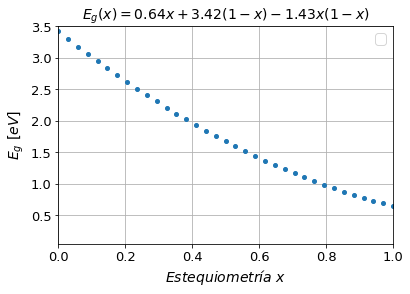

In [2]:
#Parameters of GaN and InN
Eg_InN,  Eg_GaN  = 0.65,              3.42
Per_InN, Per_GaN = 15.3,              8.9              
Nc_InN,  Nc_GaN  = 0.9 * 10 ** 18,    2.3 * 10 ** 18
Nv_InN,  Nv_GaN  = 5.3 * 10 ** 19,    1.8 * 10 ** 19
Dn_InN,  Dn_GaN  = 80,                39 
Dp_InN,  Dp_GaN  = 8,                 0.75
taon_InN, Taon_GaN = 1 * 10 ** -9,     0.1 * 10 ** -9    
taop_InN, Taop_GaN = 5.4* 10 ** -9,     7 * 10 ** -9      

#Calculation of material properties
def DOS(m):
    k_ = Kb * q # for units
    h_ = h * q  # for units
    return 2 * (2 * np.pi * m * m0 * k_ * T / (h_ ** 2)) ** 1.5 / 1000000
def Difusivity(mob): return (Kb * T) * mob
def intrinsic(Nc, Nv, Eg): return (Nc * Nv) ** 0.5 * np.exp(- Eg / (2 * Kb * T))
def pn0(ni, N): return (ni ** 2 / N)
def Diffusion_Length(D,t): return (D * t) ** 0.5
def EgInGaN(X): return X * Eg_InN + (1 - X) * Eg_GaN - 1.43 * X * (1 - X)
def electron_effective_mass(X): return 0.12 * X + 0.2 * (1 - X)  
def hole_effective_mass(X): return 0.17 * X + 1 * (1 - X)  
def chiInGaN(x, E): return 4.1 + 0.7 * (3.4 - E)
def PermInGaN(x): return Per_InN * x + Per_GaN * (1 - x)
def electron_lifetime_InGaN(X): return taon_InN * X + Taon_GaN * (1-X) 
def hole_lifetime_InGaN(X): return taop_InN * X + Taop_GaN * (1-X) 

#Optical Absortion
x_lab = [1, 0.83, 0.69, 0.57, 0.5, 0] 
a = [0.69642, 0.66796, 0.58108, 0.60946, 0.51672, 3.52517]
b = [0.46055, 0.68886, 0.66902, 0.62182, 0.46836, -0.65710]
A1, A2, A3, A4, A5 = np.polyfit(x_lab, a, 4)
B1, B2, B3, B4, B5 = np.polyfit(x_lab, b, 4)
def cte_a(X): return A1 * X ** 4 + A2 * X ** 3 + A3 * X ** 2 + A4 * X + A5
def cte_b(X): return B1 * X ** 4 + B2 * X ** 3 + B3 * X ** 2 + B4 * X + B5
def optical_absorption(X): 
    A = cte_a(X) * ((1240/lamb) - EgInGaN(X) )
    B = cte_b(X) * ((1240/lamb) - EgInGaN(X) ) ** 2
    C = A + B
    C[np.where(C < 0)] = 0 
    return (10 ** 5) * (C) ** 0.5

#Mobility
x_values = np.array([0, 0.2, 0.5, 0.8, 1])
mmax = np.array([1460.7, 684.2, 758.1, 1252.7, 3138.4])
mmin = np.array([295,    386.4, 456.4, 644.3,  774])
cte_values = np.array([0.66, 1.37, 1.04, 0.82, 0.68])
C1, C2, C3, C4, C5 = np.polyfit(x_values, mmax, 4)
D1, D2, D3, D4, D5 = np.polyfit(x_values, mmin, 4)
E1, E2, E3, E4, E5 = np.polyfit(x_values, cte_values, 4)
def mov_max(X): return C1 * X ** 4 + C2 * X ** 3 + C3 * X ** 2 + C4 * X + C5
def mov_min(X): return D1 * X ** 4 + D2 * X ** 3 + D3 * X ** 2 + D4 * X + D5
def gamma(X): return E1 * X ** 4 + E2 * X ** 3 + E3 * X ** 2 + E4 * X + E5
def electron_mobility(X, N): 
    DEN = 1 + ((N / (1 * 10 ** 17)) ** gamma(X))
    return mov_min(X) + ( (mov_max(X) - mov_min(X)) / DEN)
def hole_mobility(X, N):
    DENInN = 1 + ((N / (3 * 10 ** 17)) ** 2)
    DENGaN = 1 + ((N / (3 * 10 ** 17)) ** 2)
    MOVInN = 3 + ( (340 - 3) / DENInN)
    MOVGaN = 3 + ( (170 - 3) / DENGaN)
    return MOVInN * X + MOVGaN * (1 - X)

#Now, we encapsulate the properties of the material type P and N
# N-type
def n_IGN_properties(conc_n, N_n):
      Eg_IGN_n    =  EgInGaN(conc_n)
      chi_IGN_n   =  chiInGaN(conc_n, Eg_IGN_n)
      Perm_IGN_n  =  PermInGaN(conc_n)
      me_IGN_n    =  electron_effective_mass(conc_n)
      mh_IGN_n    =  hole_effective_mass(conc_n)
      Nc_IGN_n    =  DOS(me_IGN_n)
      Nv_IGN_n    =  DOS(mh_IGN_n)
      Mp_IGN_n    =  hole_mobility(conc_n, N_n)  ##########
      Dp_IGN_n    =  Difusivity(Mp_IGN_n)
      tp_IGN_n    =  hole_lifetime_InGaN(conc_n)
      Lp_IGN_n    =  Diffusion_Length(Dp_IGN_n,tp_IGN_n)
      S_IGN_n     =  10 ** 3
      ni_IGN_n    =  intrinsic(Nc_IGN_n, Nv_IGN_n, Eg_IGN_n)
      alpha_IGN_n =  optical_absorption(conc_n)
      return Eg_IGN_n, chi_IGN_n, Perm_IGN_n, Nc_IGN_n, Nv_IGN_n, Dp_IGN_n, tp_IGN_n, Lp_IGN_n, S_IGN_n, ni_IGN_n, alpha_IGN_n

# P-type
def p_IGN_properties(conc_p, N_p):      
      Eg_IGN_p   =  EgInGaN(conc_p)
      chi_IGN_p  =  chiInGaN(conc_p, Eg_IGN_p)
      Perm_IGN_p =  PermInGaN(conc_p)
      me_IGN_p  =  electron_effective_mass(conc_p)
      mh_IGN_p  =  hole_effective_mass(conc_p)
      Nc_IGN_p  =  DOS(me_IGN_p)
      Nv_IGN_p  =  DOS(mh_IGN_p)
      Mn_IGN_p  =  hole_mobility(conc_p, N_p)  ##########
      Dn_IGN_p  =  Difusivity(Mn_IGN_p)
      tn_IGN_p  =  hole_lifetime_InGaN(conc_p)
      Ln_IGN_p  =  Diffusion_Length(Dn_IGN_p,tn_IGN_p)
      S_IGN_p    =  10 ** 3
      ni_IGN_p   =  intrinsic(Nc_IGN_p, Nv_IGN_p, Eg_IGN_p)
      alpha_IGN_p =  optical_absorption(conc_p)
      return Eg_IGN_p, chi_IGN_p, Perm_IGN_p, Nc_IGN_p, Nv_IGN_p, Dn_IGN_p, tn_IGN_p, Ln_IGN_p, S_IGN_p, ni_IGN_p, alpha_IGN_p, 0, 1

#Visualization of band gap
import matplotlib as mpl
params = {'xtick.labelsize': 13, 'ytick.labelsize': 13, 'legend.title_fontsize' : 20}
mpl.rcParams.update(params)
ejes = 14
fig, ax = plt.subplots()
x = np.linspace(0, 1, 35)
plt.legend(fontsize = 14, loc = 'upper right')
ax.plot(x, EgInGaN(x), 'o', linewidth = 2, markersize = 4, label = r'$E_{g}(x) = 0.64 x + 3.42 (1-x) - 1.43 x (1-x)$');
plt.grid()
plt.ylabel(r'$E_{g} \ [eV]$', fontsize = ejes)
plt.xlabel(r'$Estequiometría \ x$', fontsize = ejes)
plt.xlim(0, 1)
plt.ylim(0.05, 3.5)
plt.title(r'$E_{g}(x) = 0.64 x + 3.42 (1-x) - 1.43 x (1-x)$', fontsize = ejes);

#2. Basic Functions for simulate J vs V behaviour

## 2.1. Basic functions 
Functions for Calculate the photoelectric response of a single cell

In [3]:
# Built-in potential  -------------------------------------------------------------------------
def Vbi(Egn, Egp, chin, chip, Nd, Na, Ncn, Ncp, Nvn, Nvp, nin, nip): 
    delta_gap = Egn - Egp
    delta_ec  = chip - chin
    delta_ev  = delta_gap - delta_ec
    A = (delta_ec - delta_ev) / 2
    B = Kb * T * np.log(Nd * Na / (nin * nip))
    C = 0.5 * Kb * T * np.log(Ncp * Nvn / (Ncn * Nvp))
    return A + B + C

# Depletion region xn y xp --------------------------------------------------------------------
def region(a, b, epsn, epsp, Nd, Na, Vbi, V):
    A = 2 * epsp * epsn * eps_0 * a * (Vbi - V) * 100
    B = q * b * (epsn * Nd + epsp * Na)
    return (A / B) ** 0.5

# Photocurrent densities ----------------------------------------------------------------------
def dJp(sp, Lp, Dp, wn, xn, alpha1, Ref, Trans):
    cte1 = sp * Lp / Dp
    cte2 = wn - xn
    angulo = (wn - xn) / Lp
    A = q * photon_flux * (1 - Ref) * Trans * alpha1 * Lp
    B = ((alpha1 ** 2) * (Lp ** 2) ) - 1
    C = cte1 + (alpha1 * Lp)
    D = np.exp(- (alpha1 * cte2))
    E = ( cte1 * np.cosh(angulo) ) + np.sinh(angulo)
    F = ( cte1 * np.sinh(angulo) ) + np.cosh(angulo)
    G = alpha1 * Lp * np.exp( - alpha1 * cte2)
    return (A / B) *  ( ((C - D * E) / F) - G)  

def dJn(sn, Ln, Dn, wp, xp, alpha2, wn, alpha1, Ref, Trans):
    cte1 = sn * Ln / Dn
    cte2 = wp - xp
    angulo = (wp - xp) / Ln    
    A = q * photon_flux * (1 - Ref) * Trans * alpha2 * Ln
    B = np.exp(-(alpha1 * wn + alpha2 * xp))
    C = ((alpha2 ** 2) * (Ln ** 2)) - 1
    D = alpha2 * Ln
    E = cte1 * (np.cosh(angulo) - np.exp( - alpha2 * cte2 ) )
    F = np.sinh(angulo) 
    G = alpha2 * Ln * np.exp(- alpha2 * cte2)
    H = cte1 * np.sinh(angulo)
    I = np.cosh(angulo)
    return (A * B / C) * (D - ( (E + F + G ) / (H + I) ))

def dJscr(xn, xp, wn, alpha1, alpha2 , Ref, Trans):
    A = q * photon_flux * (1 - Ref) * Trans * np.exp( - alpha1 * (wn - xn))
    B = 1 - np.exp( - alpha1 * xn)
    C = np.exp( - alpha1 * xn) * (1 - np.exp(- alpha2 * xp))
    return A * (B + C)

def Jph(dj_n, dj_p, dj_scr):
  return integrate.simps(dj_p + dj_n + dj_scr)


# Saturation current density J0, J0p y J0n ----------------------------------------------------
def J0pn(D, pn0, L, s, w, x): 
    A = q * D * pn0 / L
    B = s * L / D
    ang = (w - x) / L
    return A * (B * np.cosh(ang) + np.sinh(ang) ) / (B * np.sinh(ang) + np.cosh(ang))
def J0(j0_n, j0_p):
  return j0_n + j0_p

# Saturation current density J00 --------------------------------------------------------------
def J00(xn, xp, nin, nip, Lp, Ln, Dp, Dn):   
    taop = (Lp ** 2) / Dp
    taon = (Ln ** 2) / Dn
    return q * ( (xn * nin / taop) + (xp * nip / taon))

# Dark current density ------------------------------------------------------------------------
def Jdark(j_0, j_00, v):
    return (j_0 * (np.exp(v / (Kb * T)) - 1)) + (j_00 * (np.exp(v / (2 * Kb * T)) - 1))

## 2.2. Basic simulation

* Function for simulate J vs V behavior.
* We call this function as base_simulation

In [4]:
#  We must properly set the numbers of V_list values ​​to avoid excess operations
V_list = np.linspace(0, 3, 51)

def base_simulation(N_n, N_p, w_IGN_n, w_IGN_p, conc_n, conc_p):
    
    # DATA CONTAINERS
    J_list   = [] 
    Pot_list = []

    for V in V_list:

        #POPERTIES OF MATERIALS
        Eg_IGN_n, chi_IGN_n, Perm_IGN_n, Nc_IGN_n, Nv_IGN_n, Dp_IGN_n, tp_IGN_n, Lp_IGN_n, S_IGN_n, ni_IGN_n, alpha_IGN_n = n_IGN_properties(conc_n, N_n)
        Eg_IGN_p, chi_IGN_p, Perm_IGN_p, Nc_IGN_p, Nv_IGN_p, Dn_IGN_p, tn_IGN_p, Ln_IGN_p, S_IGN_p, ni_IGN_p, alpha_IGN_p, Ref, Trans = p_IGN_properties(conc_p, N_p)

        #CORRESPONDENCES WITH THE MODEL EQUATIONS
        Eg_n,  Eg_p  = Eg_IGN_p,        Eg_IGN_n
        chi_n, chi_p = chi_IGN_p,       chi_IGN_n
        N_d,   N_a   = N_p,             N_n
        Nc_n,  Nc_p  = Nc_IGN_p,        Nc_IGN_n
        Nv_n,  Nv_p  = Nv_IGN_p,        Nv_IGN_n
        eps_n, eps_p = Perm_IGN_p,      Perm_IGN_n
        D_p,   D_n   = Dn_IGN_p,        Dp_IGN_n
        L_p,   L_n   = Ln_IGN_p,        Lp_IGN_n
        s_p,   s_n   = S_IGN_p,         S_IGN_n
        w_n,   w_p   = w_IGN_p,         w_IGN_n 
        alpha_1 = alpha_IGN_p
        alpha_2 = alpha_IGN_n
        ni_n = ni_IGN_p
        ni_p = ni_IGN_n
        n_0  =  pn0(ni_p, N_a)    #p
        p_0  =  pn0(ni_n, N_d)    #n

        # CALCULATIONS --------------------------------------------------------------------------------------------

        # Built-in potential --------------------------------------------------------------
        V_bi =  Vbi(Eg_n, Eg_p, chi_n, chi_p, N_d, N_a, Nc_n, Nc_p, Nv_n, Nv_p, ni_n, ni_p)        

        # Depletion region ----------------------------------------------------------------
        x_n  =  region(N_a, N_d, eps_n, eps_p, N_d, N_a, V_bi, V)
        x_p  =  region(N_d, N_a, eps_n, eps_p, N_d, N_a, V_bi, V)

        if x_n > w_n:  # Condition in case the depletion region exceeds the material width
            x_n = w_n
            x_p = w_n * (N_d / N_a)
        if x_p > w_p:  # Condition in case the depletion region exceeds the material width
            x_p = w_p
            x_n = w_p * (N_a / N_d)
      
        # Photocurrent --------------------------------------------------------------------
        dj_p    =  dJp(s_p, L_p, D_p, w_n, x_n, alpha_1, Ref, Trans)
        dj_n    =  dJn(s_n, L_n, D_n, w_p, x_p, alpha_2, w_n, alpha_1, Ref, Trans)  
        dj_scr  =  dJscr(x_n, x_p, w_n, alpha_1, alpha_2 , Ref, Trans)
        j_ph    =  Jph(dj_n, dj_p, dj_scr)
        # Saturation current density J0 ---------------------------------------------------
        j0_p    =  J0pn(D_p, p_0, L_p, s_p, w_n, x_n)
        j0_n    =  J0pn(D_n, n_0, L_n, s_n, w_p, x_p)
        j_0     =  J0(j0_n, j0_p)
        # Saturation current density J00 --------------------------------------------------
        j_00    =  J00(x_n, x_p, ni_n, ni_p, L_p, L_n, D_p, D_n)
        # Dark current density ------------------------------------------------------------
        j_dark  =  Jdark(j_0, j_00, V)
        # Cell current density ------------------------------------------------------------
        j_cell  =  j_ph - j_dark
        J_list.append(j_cell)

        Pot_list.append(V * j_cell)

    return J_list, Pot_list

## 2.3 Characteristic values

We use a helper function called 'CHARACTERISTICS_VALUES' for get Voc, Jsc, FF and efficiency.

In [5]:
def CHARACTERISTICS_VALUES(J_list, Pot_list, V_list):
    Positives = [x for x in J_list if x > 0]
    Position = len(Positives)
    x1, x2 = V_list[Position - 1], V_list[Position]
    y1, y2 = J_list[Position - 1], J_list[Position]
    m = (y2 - y1) / (x2 - x1)
    V_oc = (- y1 / m) + x1
    J_sc = J_list[0] * 1000
    Pot_list_ = [x for x in Pot_list if str(x) != 'nan']
    Position = int(np.where(Pot_list_ == np.amax(Pot_list_))[0])
    V_mpp = V_list[Position] 
    J_mpp = J_list[Position] * 1000
    FF = ((J_mpp * V_mpp) / (J_sc * V_oc)) * 100
    Eff = (J_mpp * V_mpp) / P_inc
    return V_oc, J_sc, FF, Eff


# 3. SIMULATIONS (varying thickness and stoichiometry)

## 3.1) J vs V behaviour

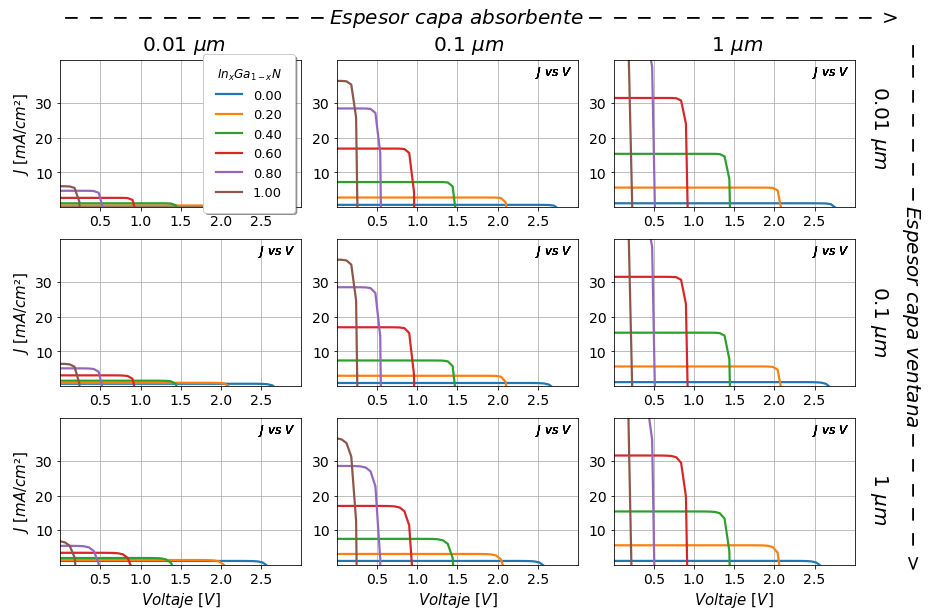

In [6]:
#Libreries and values of visualization
from itertools import product
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
params = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.title_fontsize' : 12}
mpl.rcParams.update(params)
labels_size = 15

#Function to graph
def individual_graph_J(ax):
    for i, j in enumerate(conc_n_list):
      ax.plot(V_list, np.array(J_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2.2)
      ax.set_xlim(0, 3)
      ax.set_ylim(0, 42.5)
      ax.text(2.7, 39, r"$J\ vs\ V$", ha="center", va="center", size = 12)
      ax.grid('on')
      ax.set_xticks([0.5, 1, 1.5, 2, 2.5])
      ax.set_yticks([10, 20, 30])        
      plt.tight_layout()

#SIMULATION ----------------------------------------------------------------------------------------

N_n = 10 ** 16
N_p = 10 ** 14
w_IGN_p_list   =  np.array([0.01, 0.1, 1]) * 10 ** -4
w_IGN_n_list   =  np.array([0.01, 0.1, 1]) * 10 ** -4
conc_p      = 0
conc_n_list = np.linspace(0,1, 6)
cross_product = list(product(w_IGN_p_list, w_IGN_n_list))
ubication = list(product([0,1,2], [0,1,2]))

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12, 8)
cont = 0
for w_IGN_p, w_IGN_n in cross_product:
    J_lists, Pot_lists = [], []
    Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], [] 
    for conc_n in conc_n_list:
        J_list, Pot_list = base_simulation(N_n, N_p, w_IGN_n, w_IGN_p, conc_n, conc_p)
        J_lists.append(J_list)
        Pot_lists.append(Pot_list)
        Voc, Jsc, FF, Eff = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)        
        Jsc_list.append(Jsc)
        Voc_list.append(Voc)
        FF_list.append(FF)
        Eff_list.append(Eff)
    a, b = ubication[cont]    
    individual_graph_J(ax[a,b]);
    if cont in [0]: ax[a,b].legend(title = r'$In_{x}Ga_{1-x}N$', fontsize = 13, fancybox=True, framealpha=1, shadow=True, borderpad=1, loc = 'right')
    if cont in [6, 7, 8]: ax[a,b].set_xlabel(r'$Voltaje\ [V]$', size = labels_size)
    if cont in [0,3,6]: ax[a, b].set_ylabel(r'$J\ [mA/cm²]$', size = labels_size) 
    cont += 1

plt.text(-2, 158, r"$\ \ \ \ \ \ \ \ -----------Espesor \ capa \ absorbente------------>    $", ha="center", va="center", size = 20)
plt.text(-2, 150, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.01,'\ '* 32 , 0.1, '\ '* 32 ,1), ha="center", va="center", size = 20)
plt.text(3.7, 75, r"$-------Espesor \ capa \ ventana----->$", ha="center", va="center", rotation=270, size = 20)
plt.text(3.3, 75, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.01,'\ '* 18 ,0.1, '\ '* 18 ,1), ha="center", va="center", rotation=270, size = 20)
plt.show()

## 3.2) P vs V behaviour

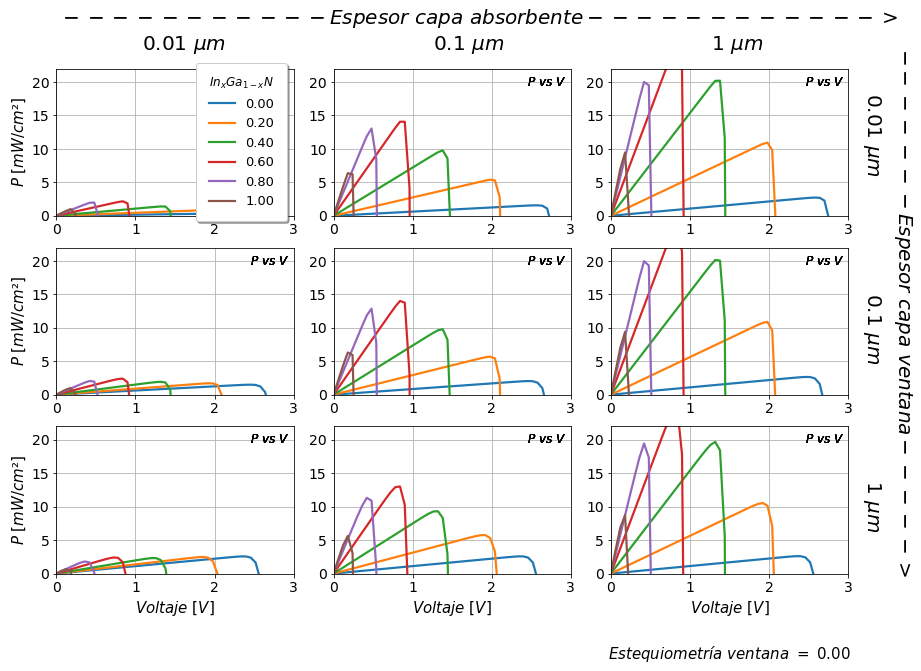

In [7]:
#Function to graph
def individual_graph_P(ax):
    for i, j in enumerate(conc_n_list):
      ax.plot(V_list, np.array(Pot_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2.2)
      ax.set_xlim(0, 3)
      ax.set_ylim(0, 22)
      ax.text(2.7, 20, r"$P\ vs\ V$", ha="center", va="center", size = 12)
      ax.grid('on')
      plt.tight_layout()

#SIMULATION -------------------------------------------------------------

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12, 8)
cont = 0
for w_IGN_p, w_IGN_n in cross_product:
    J_lists, Pot_lists = [], []
    Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], [] 
    for conc_n in conc_n_list:
        J_list, Pot_list = base_simulation(N_n, N_p, w_IGN_n, w_IGN_p, conc_n, conc_p)
        J_lists.append(J_list)
        Pot_lists.append(Pot_list )
        Voc, Jsc, FF, Eff = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)        
        Jsc_list.append(Jsc)
        Voc_list.append(Voc)
        FF_list.append(FF)
        Eff_list.append(Eff)
    
    a, b = ubication[cont]    
    individual_graph_P(ax[a,b])
    if cont in [0]: ax[a,b].legend(title = r'$In_{x}Ga_{1-x}N$', fontsize = 13, fancybox=True, framealpha=1, shadow=True, borderpad=1, loc = 'right')
    if cont in [6, 7, 8]: ax[a,b].set_xlabel(r'$Voltaje\ [V]$', size = labels_size)
    if cont in [0,3,6]: ax[a, b].set_ylabel(r'$P\ [mW/cm²]$', size = labels_size)   
    cont += 1
      
ax[a,b].text(1.5,-12, r'$Estequiometría \ ventana \ = \ {:.2f}$'.format(conc_p), ha="center", va="center", size = 15)
ax[a,b].text(-2, 83, r"$\ \ \ \ \ \ \ \ -----------Espesor \ capa \ absorbente------------>    $", ha="center", va="center", size = 20)
ax[a,b].text(-2, 79, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.01,'\ '* 32 , 0.1, '\ '* 32 ,1), ha="center", va="center", size = 20)
ax[a,b].text(3.7, 39, r"$-------Espesor \ capa \ ventana----->$", ha="center", va="center", rotation=270, size = 20)
ax[a,b].text(3.3, 39, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.01,'\ '* 18 ,0.1, '\ '* 18 ,1), ha="center", va="center", rotation=270, size = 20)
plt.show()

## 3.3) Comparative between J and P

Text(-1.4, 63, '$0.01\\ \\mu m \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\  0.1\\ \\mu m \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\ \\  1\\ \\mu m $')

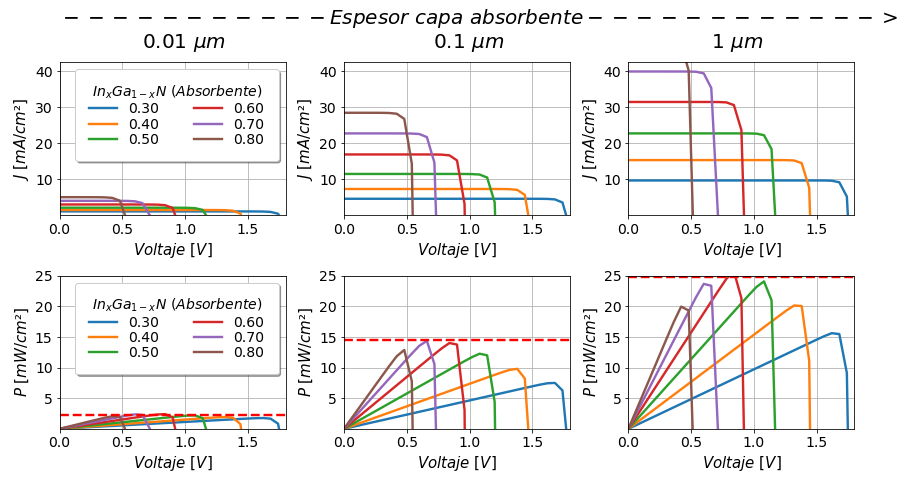

In [8]:
# Params to graph
xlim = 1.8
label_size = 15
legend_size = 14
line_width = 2.4
params = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.title_fontsize' : 14, "legend.columnspacing" : 2.5, "legend.labelspacing": 0.1}
mpl.rcParams.update(params)

# Graph J
def Current_graph(ax):
    for i, j in enumerate(conc_n_list):
      ax.plot(V_list, np.array(J_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = line_width)
      ax.set_xlim(0, xlim)
      ax.set_ylim(0, 42.5)
      ax.grid('on')
      ax.set_yticks([10, 20, 30, 40])     
      ax.set_xlabel(r'$Voltaje\ [V]$', size = label_size)
      ax.set_ylabel(r'$J\ [mA/cm²]$', size = label_size)    
      if cont == 0: ax.legend(title = r'$In_{x}Ga_{1-x}N\ (Absorbente)$', fontsize = legend_size, ncol = 2, fancybox=True, framealpha=1, shadow=True, borderpad=1, loc = 'best')
      plt.tight_layout()

# Graph P
def Power_graph(ax):
    for i, j in enumerate(conc_n_list):
      ax.plot(V_list, np.array(Pot_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = line_width)
      ax.set_xlim(0, xlim)
      ax.set_ylim(0, 25)
      ax.grid('on')
      ax.set_yticks([5, 10, 15, 20, 25])  
      ax.set_xlabel(r'$Voltaje\ [V]$', size = label_size)
      ax.set_ylabel(r'$P\ [mW/cm²]$', size = label_size)       
      if cont == 0: ax.legend(title = r'$In_{x}Ga_{1-x}N\ (Absorbente)$', fontsize = legend_size, ncol = 2, fancybox=True, framealpha=1, shadow=True, borderpad=1, loc = 'best')
      plt.tight_layout()
    if cont == 0: ax.axhline(2.2, c = 'r', ls = '--', lw = 2.4)
    if cont == 1: ax.axhline(14.5, c = 'r', ls = '--', lw = 2.4)
    if cont == 2: ax.axhline(24.8, c = 'r', ls = '--', lw = 2.4)

#SIMULATION ----------------------------------------------------------------------------------------------------------------

N_n = 10 ** 16
N_p = 10 ** 14
w_IGN_p       =  0.1 * 10 ** -4
w_IGN_n_list  =  np.array([0.01, 0.1, 1]) * 10 ** -4
conc_p      = 0
conc_n_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(12, 6)
cont = 0
for w_IGN_n in w_IGN_n_list:
    J_lists, Pot_lists = [], []
    Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], [] 
    for conc_n in conc_n_list:
        J_list, Pot_list = base_simulation(N_n, N_p, w_IGN_n, w_IGN_p, conc_n, conc_p)
        J_lists.append(J_list)
        Pot_lists.append(Pot_list )
        Voc, Jsc, FF, Eff = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)        
        Jsc_list.append(Jsc)
        Voc_list.append(Voc)
        FF_list.append(FF)
        Eff_list.append(Eff)  
    Current_graph(ax[0,cont])
    Power_graph(ax[1, cont])  
    cont += 1

plt.text(-1.4, 67, r"$\ \ \ \ \ \ \ \ -----------Espesor \ capa \ absorbente------------>    $", ha="center", va="center", size = 20)
plt.text(-1.4, 63, r"${}\ \mu m {} {}\ \mu m {} {}\ \mu m $".format(0.01,'\ '* 32 , 0.1, '\ '* 32 ,1), ha="center", va="center", size = 20)

## 3.4) Simulation Pmpp (Max Power Point) 

The results are represented on color maps as a function of the thickness of the Silicon and InGaN

In [9]:
# Time meter and image parameters
%%time
params = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.title_fontsize' : 12}
mpl.rcParams.update(params)
pixels = 20

# Containers
Pmpp_data = []
Voc_data  = []
Jsc_data  = []

# Parameters
N_n = 10 ** 16
N_p = 10 ** 14
conc_n = 0.6
conc_p_list = [0, 0.25, 0.5]
w_IGN_p_list  =  np.logspace(-6, -2.5, pixels) 
w_IGN_n_list =  np.logspace(-5.8, -2, pixels)
cross_product = list(product(w_IGN_p_list, w_IGN_n_list))

# SIMULATION ----------------------------------------------------------------------------------------
cont = 1
for conc_p in conc_p_list: 
    J_lists, Pot_lists = [], []
    Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
    Pmpp_list = []

    for w_IGN_p, w_IGN_n in cross_product:
        J_list, Pot_list = base_simulation(N_n, N_p, w_IGN_n, w_IGN_p, conc_n, conc_p)
        Pot_list = np.array(Pot_list)
        Pmpp_list.append(np.amax(Pot_list[Pot_list >= 0]))
        J_lists.append(J_list)
        Pot_lists.append(Pot_list)
        Voc, Jsc, FF, Eff = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
        Jsc_list.append(Jsc)
        Voc_list.append(Voc)
        FF_list.append(FF)
        Eff_list.append(Eff)

    Pmpp_results = (np.array(Pmpp_list) * 1000).reshape(pixels, -1)
    Pmpp_data.append(Pmpp_results)
    Voc_results = (np.array(Voc_list)).reshape(pixels, -1)
    Voc_data.append(Voc_results)
    Jsc_results = (np.array(Jsc_list)).reshape(pixels, -1)
    Jsc_data.append(Jsc_results)
    print('advance --')

advance --
advance --
advance --
CPU times: user 40.4 s, sys: 54.9 ms, total: 40.5 s
Wall time: 40.6 s


0.25797665069637626

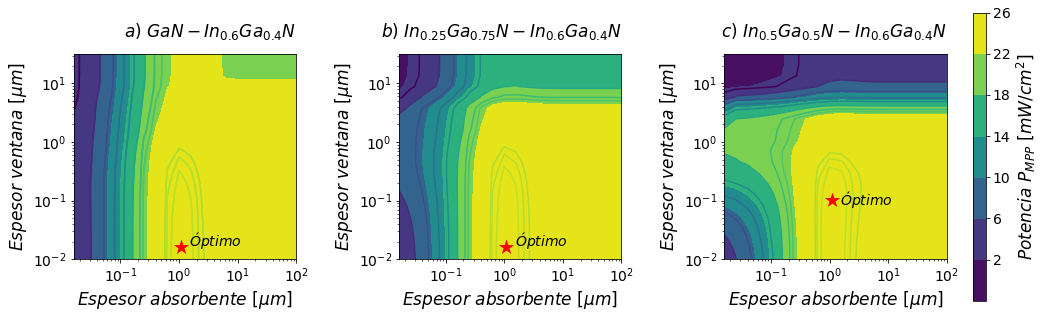

In [10]:
# Graphs of the previous simulations

# Aditional lists, for label the graphs
lista_1 = [0.1, 0.2,0.3, 0.4, 0.5, 0.6,0.7, 0.8, 0.9]
lista_1 = [0.25, 0.5, 0.75]
lista_2 =  lista_1[::-1]
lista_3 = ['b)\ ', 'c)\ ','c)\ ', 'd)\ ','d)\ ', 'e)\ ', 'e)\ ','e)\ ']
Names = ['a)\ GaN-In_{0.6}Ga_{0.4}N']
cont = 0
for i,j in zip(lista_1, lista_2):
  Names.append(lista_3[cont] + 'In_{' + str(i) + '}Ga_{' + str(j) + '}N-In_{0.6}Ga_{0.4}N')
  cont += 1
Names.append('f)\ InN-In_{0.6}Ga_{0.4}N')


# Image parameters
labelsize = 17
min = 0
max= 25
levels = [0, 2, 6, 10, 14, 18, 22, 26]
levels2 = [0, 3, 6, 9, 12, 15, 18, 20, 21, 25 , 25.25, 25.5]
conc_n_list = np.linspace(0,1, 6)
lines = 15
lineslines = 30
lim = 199.9
lim2 = 200.1


#Colormaps results visualization

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches((12, 5))
i = 0
for ax in axes.flat:    
    if i == 0:
          imag = ax.contour(w_IGN_n_list *10 ** 4, w_IGN_p_list * 10 ** 4, Pmpp_data[i], lineslines, vmin = min + 3, vmax = max + 3,line_width = 0.1, levels = levels2)#, cmap = set_color)
          imag = ax.contourf(w_IGN_n_list *10 ** 4, w_IGN_p_list * 10 ** 4, Pmpp_data[i],lines, vmin = min, vmax = max, levels = levels)#, cmap = set_color)
          plt.tight_layout()
    im = ax.contour(w_IGN_n_list *10 ** 4, w_IGN_p_list * 10 ** 4, Pmpp_data[i], lineslines, vmin = min + 3, vmax = max + 3, levels = levels2)#, cmap = set_color)
    im = ax.contourf(w_IGN_n_list *10 ** 4, w_IGN_p_list * 10 ** 4, Pmpp_data[i],lines,  vmin = min, vmax = max, levels = levels)#, cmap = set_color)
    ax.set_xscale('log')
    ax.set_yscale('log')    
    ax.text((w_IGN_n_list[-1] * 10 ** 4 ) , w_IGN_p_list[-1] * 10 ** 4 + 20, s = r'${}$'.format(Names[i]), fontsize = 17, ha = 'right', va = 'bottom')
    ax.set_aspect('equal')
    plt.tight_layout()
    pos = np.where(Pmpp_data[i] == np.amax(Pmpp_data[i]))
    a = pos[0][0]
    b = pos[1][0]
    c = '{:.2f}'.format(Pmpp_data[i][a][b])
    ax.text(x = w_IGN_n_list[b] * 10**4 , y = w_IGN_n_list[a] * 10 ** 4 , s = r'$\star $', fontsize = 40, ha = 'center', va = 'center', color = 'r')
    ax.text(x = 1.5 * w_IGN_n_list[b] * 10**4 , y = w_IGN_n_list[a] * 10 ** 4 + 0.005, s = r'$Óptimo $', fontsize = 14, ha = 'left', va = 'center', color = 'k')
    mask = (Pmpp_data[i] > lim) & (Pmpp_data[i] < lim2)
    listado = np.where(mask)
    y = listado[0]
    x = listado[1]
    x = x[x%3 == 0]
    y = y[y%3 == 0]
    for a,b in zip(y,x):
      ax.text(x = w_IGN_n_list[b] * 10**4 , y = w_IGN_p_list[a] * 10 ** 4, s = r'$.$', fontsize = 15, ha = 'center', va = 'bottom', color = 'k')
    ax.set_xlabel(r'$Espesor\ absorbente\ [\mu m]$', fontsize = labelsize)
    ax.set_ylabel(r'$Espesor\ ventana\ [\mu m]$',   fontsize = labelsize)   
    i += 1

fig.tight_layout()
fig.subplots_adjust(right=1.1)
cbar_ax = fig.add_axes([1.13, 0.1, 0.015, 0.8])
cbar = fig.colorbar(imag,extend = 'max', cax=cbar_ax, label='digit value', ticks = [2, 6, 10, 14, 18, 22, 26])
cbar.set_label(r"$Potencia\ P_{MPP}\ [mW/cm^{2}]$", size = 17)
np.amax(np.array(Eff_list))

## 3.5) Jsc, Voc, FF, eff results


In [11]:
#functions to graph
def J_V_GRAPH(V_list, J_lists, xlim = 0.8, ylim = 43, label_size = 15, legend_size = 15, title_size = 18, title_legend = r'$In_{X}Ga_{1-x}N$'):
    for i, j in enumerate(conc_n_list):
        if conc_n_list[i] > 0.75:
          plt.plot(V_list, np.array(J_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2, ls = '--')
        else:
          plt.plot(V_list, np.array(J_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2.2)
    plt.title(r'$1.\ Densidad\ de\ corriente$', fontsize = title_size)
    #plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.xlabel(r'$Voltaje\ [V]$', fontsize = label_size)
    plt.ylabel(r'$J\ [mA/cm^{2}]$', fontsize = label_size)
    plt.legend(fontsize = legend_size, loc = 'best', title = title_legend)
    plt.grid('on')
    plt.tight_layout()

def P_V_GRAPH(V_list, Pot_lists, xlim = 0.8, ylim = 25, label_size = 15, legend_size = 15, title_size = 18, title_legend = r'$In_{X}Ga_{1-x}N$'):
    for i, j in enumerate(conc_n_list):
        if conc_n_list[i] > 0.75:
          plt.plot(V_list, np.array(Pot_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2, ls = '--')
        else:
          plt.plot(V_list, np.array(Pot_lists[i]) * 10 ** 3, label = '{:.2f}'.format(j), lw = 2.2)
    plt.title(r'$2.\ Densidad\ de\ potencia$', fontsize = title_size)
    plt.ylim(0, ylim)
    plt.xlabel(r'$Voltaje\ [V]$', fontsize = label_size)
    plt.ylabel(r'$P\ [mW/cm^{2}]$', fontsize = label_size)
    plt.legend(fontsize = legend_size, loc = 'best', title = title_legend)
    plt.grid('on')
    plt.tight_layout()

def characteristic_graph(conc_n_list, data, title, ylabel, limits, axes_size = 12, title_size = 12):
      plt.plot(conc_n_list, data, lw = 2.5)
      plt.ylim(limits[0], limits[1])
      plt.xlim(0.2,0.8)
      plt.xticks(np.linspace(0.2,0.8, 7))
      plt.ylabel(ylabel = ylabel, fontsize = axes_size)
      plt.title(label = title, fontsize = title_size)
      plt.xlabel(r'$x\ $', fontsize = axes_size)
      plt.grid()

In [ ]:
# SIMULATION ----------------------------------------------------------------------------

V_list = np.linspace(0, 3, 250)
J_lists, Pot_lists = [], []
Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []
N_n =  1 * 10 ** 16
N_p =  1 * 10 ** 14
w_IGN_p     = 0.01 * 10 ** - 4
w_IGN_n     = 0.963 * 10 ** - 4
conc_p = 0
conc_n_list = list(np.linspace(0, 1, 6)) #[0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1]#np.linspace(0.15, 0.9, 6)

for conc_n in conc_n_list:
    J_list, Pot_list = base_simulation(N_n, N_p, w_IGN_n, w_IGN_p, conc_n, conc_p)
    J_lists.append(J_list)
    Pot_lists.append(Pot_list)
    Voc, Jsc, FF, Eff = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
    Jsc_list.append(Jsc)
    Voc_list.append(Voc)
    FF_list.append(FF)
    Eff_list.append(Eff)

J_lists_, Pot_lists_ = [], []
Jsc_list_, Voc_list_, FF_list_, Eff_list_ = [], [], [], []
conc_n_list_ = np.round(np.arange(0.2, 0.81, 0.01), 2)
for conc_n in conc_n_list_:
    J_list_, Pot_list_ = base_simulation(N_n, N_p, w_IGN_n, w_IGN_p, conc_n, conc_p)
    J_lists_.append(J_list_)
    Pot_lists_.append(Pot_list_)
    Voc_, Jsc_, FF_, Eff_ = CHARACTERISTICS_VALUES(J_list_, Pot_list_, V_list)
    Jsc_list_.append(Jsc_)
    Voc_list_.append(Voc_)
    FF_list_.append(FF_)
    Eff_list_.append(Eff_)


# Graphs

title_size = 18
axes_size = 15
params = {'xtick.labelsize': 13, 'ytick.labelsize': 13, 'legend.title_fontsize' : 17}
mpl.rcParams.update(params)

map_label = {(0, 0) : r'$Jsc\ [mA/cm^{2}]$', 
             (0, 1) : r'$Voc\ [V]$',
             (1, 0) : r'$FF\ [\%]$',
             (1, 1) : r'$\eta\ [\%]$'}
map_title = {(0, 0) : r'$a.Corriente\ Jsc$', 
             (0, 1) : r'$b.Voltaje\ Voc$',
             (1, 0) : r'$c.Factor\ de\ llenado$',
             (1, 1) : r'$d.Eficiencia$'}
rows = 3
columns = 4

fig = plt.figure(figsize=(16, 12))
grid = plt.GridSpec(rows, columns, wspace = .4, hspace = .4)
plt.subplot(grid[:2, :2])
J_V_GRAPH(V_list, J_lists)
plt.subplot(grid[:2, 2:])
P_V_GRAPH(V_list, Pot_lists)
plt.subplot(grid[2, 0])
characteristic_graph(conc_n_list_,  Jsc_list_, map_title[(0, 0)], map_label[(0, 0)], (1, 45))
plt.subplot(grid[2, 1])
characteristic_graph(conc_n_list_,  Voc_list_, map_title[(0, 1)], map_label[(0, 1)], (0.1, 3))
plt.tight_layout()
plt.subplot(grid[2, 2])
characteristic_graph(conc_n_list_,  FF_list_, map_title[(1, 0)], map_label[(1, 0)], (41, 95))
plt.tight_layout()
plt.subplot(grid[2, 3])
characteristic_graph(conc_n_list_,  np.array(Eff_list_) * 100, map_title[(1, 1)], map_label[(1, 1)], (10, 25.5))
plt.tight_layout()

## 3.6) Other results. Varying the doping

In [ ]:
#Functions for graphs

def J_V_GRAPH(V_list, J_lists, N_LIST, xlim = 1, ylim = 43, label_size = 15, legend_size = 15, title_size = 18, title_legend = r'$In_{X}Ga_{1-x}N$'):
    for i, j in enumerate(N_LIST):
        plt.plot(V_list, np.array(J_lists[i]) * 10 ** 3, label = '{:.2e}'.format(j), lw = 2.2)
    plt.title(r'$1.\ Densidad\ de\ corriente$', fontsize = title_size)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.xlabel(r'$Voltaje\ [V]$', fontsize = label_size)
    plt.ylabel(r'$J\ [mA/cm^{2}]$', fontsize = label_size)

    plt.grid('on')
    plt.tight_layout()

def P_V_GRAPH(V_list, Pot_lists,N_LIST, xlim = 1, ylim = 25, label_size = 15, legend_size = 15, title_size = 18, title_legend = r'$In_{X}Ga_{1-x}N$'):
    for i, j in enumerate(N_LIST):
        plt.plot(V_list, np.array(Pot_lists[i]) * 10 ** 3, label = '{:.2e}'.format(j), lw = 2.2)
    plt.title(r'$2.\ Densidad\ de\ potencia$', fontsize = title_size)
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)
    plt.xlabel(r'$Voltaje\ [V]$', fontsize = label_size)
    plt.ylabel(r'$P\ [mW/cm^{2}]$', fontsize = label_size)
    plt.grid('on')
    plt.tight_layout()

def characteristic_graph(conc_n_list, data, N_LIST, title, ylabel, limits, axes_size = 13, title_size = 15):
      plt.plot(N_LIST, data, lw = 2.5)
      plt.ylim(limits[0], limits[1])
      plt.xticks(np.linspace(0.2,0.8, 7))
      plt.ylabel(ylabel = ylabel, fontsize = axes_size)
      plt.title(label = title, fontsize = title_size)
      plt.xlabel(r'$Estequiometría\ $', fontsize = axes_size)
      plt.grid()
      plt.xscale('log')

In [ ]:
#SIMULATION ------------------------------------------------------------------------------------------
V_list = np.linspace(0, 3, 201)
J_lists, Pot_lists = [], []
Jsc_list, Voc_list, FF_list, Eff_list = [], [], [], []

w_IGN_p     = 0.01 * 10 ** - 4
w_IGN_n     = 1 * 10 ** - 4
N_n =  1 * 10 ** 16
N_p =  1 * 10 ** 14

conc_p = 0.3
conc_n = 0.6
conc_n_list = list(np.linspace(0, 1, 11)) #[0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1]#np.linspace(0.15, 0.9, 6)
N_LIST1 = np.logspace(13, 19, 7)

for N_p in N_LIST1:
    J_list, Pot_list = base_simulation(N_n, N_p, w_IGN_n, w_IGN_p, conc_n, conc_p)
    J_lists.append(J_list)
    Pot_lists.append(Pot_list)
    Voc, Jsc, FF, Eff = CHARACTERISTICS_VALUES(J_list, Pot_list, V_list)
    Jsc_list.append(Jsc)
    Voc_list.append(Voc)
    FF_list.append(FF)
    Eff_list.append(Eff)
J_lists_, Pot_lists_ = [], []
Jsc_list_, Voc_list_, FF_list_, Eff_list_ = [], [], [], []

conc_n_list_ = np.linspace(0, 1, 100)
N_LIST2 = np.logspace(13, 19, 40)
for N_p in N_LIST2:
    J_list_, Pot_list_ = base_simulation(N_n, N_p, w_IGN_n, w_IGN_p, conc_n, conc_p)
    J_lists_.append(J_list_)
    Pot_lists_.append(Pot_list_)
    Voc_, Jsc_, FF_, Eff_ = CHARACTERISTICS_VALUES(J_list_, Pot_list_, V_list)
    Jsc_list_.append(Jsc_)
    Voc_list_.append(Voc_)
    FF_list_.append(FF_)
    Eff_list_.append(Eff_)


#Graphs

title_size = 18
axes_size = 15
params = {'xtick.labelsize': 13, 'ytick.labelsize': 13, 'legend.title_fontsize' : 17}
mpl.rcParams.update(params)

map_label = {(0, 0) : r'$Jsc\ [mA/cm^{2}]$', 
             (0, 1) : r'$Voc\ [V]$',
             (1, 0) : r'$FF\ [\%]$',
             (1, 1) : r'$\eta\ [\%]$'}
map_title = {(0, 0) : r'$a.Corriente\ Jsc$', 
             (0, 1) : r'$b.Voltaje\ Voc$',
             (1, 0) : r'$c.Factor\ de\ llenado$',
             (1, 1) : r'$d.Eficiencia$'}
rows = 3
columns = 4

fig = plt.figure(figsize=(16, 12))
grid = plt.GridSpec(rows, columns, wspace = .4, hspace = .4)
plt.subplot(grid[:2, :2])
J_V_GRAPH(V_list, J_lists, N_LIST1)
plt.subplot(grid[:2, 2:])
P_V_GRAPH(V_list, Pot_lists, N_LIST1)
plt.subplot(grid[2, 0])
characteristic_graph(conc_n_list_,  Jsc_list_, N_LIST2, map_title[(0, 0)], map_label[(0, 0)], (1, 45))
plt.subplot(grid[2, 1])
characteristic_graph(conc_n_list_,  Voc_list_, N_LIST2, map_title[(0, 1)], map_label[(0, 1)], (0.1, 3))
plt.tight_layout()
plt.subplot(grid[2, 2])
characteristic_graph(conc_n_list_,  FF_list_,  N_LIST2, map_title[(1, 0)], map_label[(1, 0)], (41, 95))
plt.tight_layout()
plt.subplot(grid[2, 3])
characteristic_graph(conc_n_list_,  np.array(Eff_list_) * 100, N_LIST2, map_title[(1, 1)], map_label[(1, 1)], (2.5, 26))
plt.tight_layout()